<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 6:  Web Scraping
### Finding Underpriced RVs on Craigslist

![](https://snag.gy/WrdUMx.jpg)

In this project we will be practicing our web scraping skills.  You can use Scrapy or Python requests in order to complete this project.  It may be helpful to write some prototype code in this notebook to test your assumptions, then move it into a Python file that can be run from the command line.

> In order to run code from the command line, instead of the notebook, you just need to save your code to a file (with a .py extension), and run it using the Python interpreter:<br><br>
> `python my_file.py`

You will be building a process to scrape a single category of search results on Craigslist, that can easily be applied to other categories by changing the search terms.  The main goal is to be able to target and scrape a single page given a set of parameters.

**If you use Scrapy, provide your code in a folder.**

## Import your libraries for scrapy / requests / pandas / numpy / etc
Setup whichever libraries you need. Review past material for reference.

In [66]:
# PREPARE REQUIRED LIBRARIES
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import requests
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1.  Scrape for the largest US cities (non-exhaustive list)
Search, research, and scrape Wikipedia for a list of the largest US cities.  There are a few sources but find one that is in a nice table.  We don't want all cities, just signifficant cities.  Examine your source.  Look for what can be differentiable.

- Use requests
- Build XPath query(ies)
- Extract to a list
- Clean your list

In [7]:
# SCRAPE WIKIPEDIA FOR LARGEST US CITIES (NON-EXHAUSTIVE LIST)
response = requests.get("https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population")
HTML = response.text
cities = Selector(text=HTML).xpath("//table[4]//td[2]//a/text()").extract()

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1.2 Only retain cities with properly formed ASCII

Optionally, filter out any cities with impropper ASCII characters.  A smaller list will be easier to look at.  However you may not need to filter these if you spend more time scraping a more concise city list.  This list should help you narrow down the list of regional Craigslist sites.

In [16]:
# ONLY RETAIN PROPERLY FORMED CITIES WITH FILTERING FUNCTION
cities = [c for c in cities if '[' not in c]
valid_cities = []
for c in cities:
    try: 
        valid_cities.append(str(c))
    except:
        pass
valid_cities[:5]           

['New York', 'Los Angeles', 'Chicago', 'Houston', 'Philadelphia']

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2.  Write a function to capture current pricing information via Craigslist in one city.
Choose a city from your scraped data, then go to the cooresponding city section on Craigslist, searching for "rv" in the auto section.  Write a method that pulls out the prices.

In [70]:
def pull_prices(region='sfbay'):
    resp_str = 'http://' + str(region) + '.craigslist.org/search/rva?query=rv&sort=rel'
    response = requests.get(resp_str)
    HTML = response.text
    prices = Selector(text=HTML).xpath("//div[@class='rows']/p[@class='row']//span[@class='price']/text()").extract()
    return prices

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2.1 Create a mapping of cities to cooresponding regional Craigslist URLs

Major US cities on Craigslist typically have their own cooresponding section (ie: SFBay Area, NYC, Boston, Miami, Seattle, etc).  Later, you will use these to query search results for various metropolitian regions listed on Craigslist.  Between the major metropolitan Craigslist sites, the only thing that will differ is the URL's that correspond to them.

The point of the "mapping":  Create a data structure that allows you to iterate with both the name of the city from Wikipedia, with the cooresponding variable that that will allow you to construct each craigslist URL for each region.

> For San Francsico (the Bay Area metropolitan area), the url for the RV search result is:
> http://sfbay.craigslist.org/search/sss?query=rv
>
> The convention is http://[region].craigslist.org/search/sss?query=rf
> Replacing [region] with the cooresponding city name will allow you to quickly iterate through each regional Craigslist site, and scrape the prices from the search results.  Keep this in mind while you build this "mapping".


In [29]:
city_to_reg = {c:c.replace(' ','').lower() for c in valid_cities[:10]}

# Cleaning up San Jose as it's part of sfbay region and not a distinct craiglist
city_to_reg['San Jose'] = 'sfbay'

print city_to_reg

{'Houston': 'houston', 'San Jose': 'sfbay', 'Phoenix': 'phoenix', 'Chicago': 'chicago', 'San Diego': 'sandiego', 'Philadelphia': 'philadelphia', 'Dallas': 'dallas', 'New York': 'newyork', 'Los Angeles': 'losangeles', 'San Antonio': 'sanantonio'}


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Define a function to caculate mean and median price per city.

Now that you've created a list of cities you want to scrape, adapt your solution for grabbing data in one region site, to grab data for all regional sites that you collected, then calculate the mean and median price of RV results from each city.

> Look at the URLs from a few different regions (ie: portland, phoenix, sfbay), and find what they have in common.  Determine the area in the URL string that needs to change the least, and figure out how to replace only that portion of the URL in order to iterate through each city.

In [57]:
def get_prices(city_to_reg):
    prices = {k:pull_prices(v) for k,v in city_to_reg.items()}
    
    for k,v in prices.items():
        list_prices = [float(p.replace('$','')) for p in v]
        mean_price = np.mean(list_prices)
        median_price = np.median(list_prices)
        prices[k] = (list_prices, mean_price,median_price)
    
    return prices

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Run your scraping process, and save your results to a CSV file.

In [71]:
rv_prices = get_prices(city_to_reg)
df = pd.DataFrame(rv_prices).T
df.rename(columns={0:'price_list',1:'mean',2:'median'},inplace=True)
df = df.reset_index()
df.rename(columns={'index':'City'},inplace=True)
df.to_csv('rv_prices.csv')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. Do an analysis of the RV market.

Go head we'll wait.  Anything notable about the data?

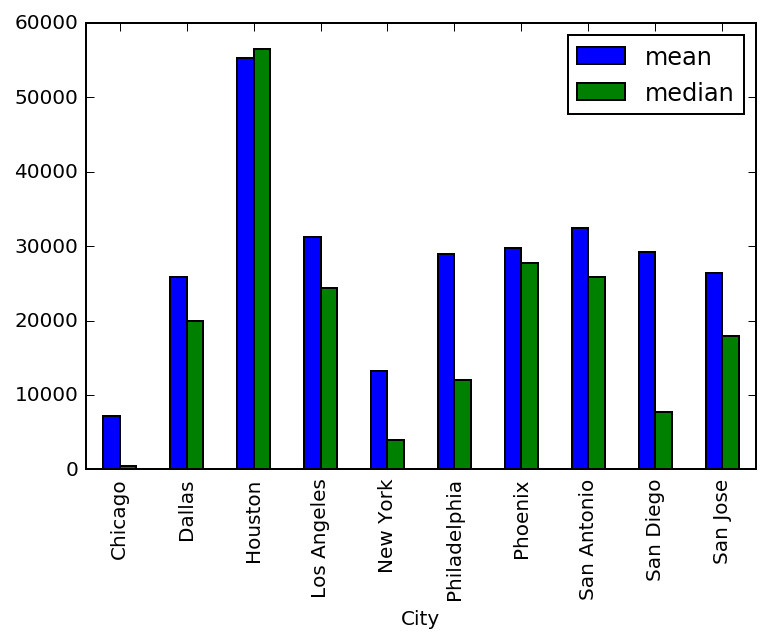

In [72]:
df.plot(x='City',y=['mean','median'],kind='bar')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5.1 Does it makes sense to buy RVs in one region and sell them in another?

Assuming the cost of shipping or driving from one regional market to another.

Based on the above it would make sense to buy from pretty much anywhere and sell the RV in Houston. This is of course assuming that the price discrepancies are not do to something like there simply being nicer RVs sold in Houston. To do a more thorough analysis would need to also grab the year, condition, make, model, and mileage of the RVs to ensure we are comparing things that should truly be priced the same. 

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5.2 Can you pull out the "make" from the markup and include that in your analyis?
How reliable is this data and does it make sense?

To do this would probably create a list for makes and models. Would then grab text from webpage and user CountVectorizer and then iterate through lists to see if words were keys in vectorizer dictionary. 

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5.3 Are there any other variables you could pull out of the markup to help describe your dataset?

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 6. Move your project into scrapy (if you haven't used Scrapy yet)

>Start a project by using the command `scrapy startproject [projectname]`
> - Update your settings.py (review our past example)
> - Update your items.py
> - Create a spiders file in your `[project_name]/[project_name]/spiders` directory

You can update your spider class with the complete list of craigslist "start urls" to effectively scrape all of the regions.  Start with one to test.

Updating your parse method with the method you chose should require minimal changes.  It will require you to update your parse method to use the response parameter, and an item model (defined in items.py).

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 7.  Chose another area of Craigslist to scrape.

**Choose an area having more than a single page of results, then scrape multiple regions, multiple pages of search results and or details pages.**

This is the true exercise of being able to understand how to succesffuly plan, develop, and employ a broader scraping strategy.  Even though this seems like a challenging task, a few tweeks of your current code can make this very managable if you've pieced together all the touch points.  If you are still confused as to some of the milestones within this process, this is an excellent opportunity to round out your understanding, or help you build a list of questions to fill in your gaps.

_Use Scrapy!  Provide your code in this project directory when you submit this project._